Trying to train a higher-level/inner network on the 64 dimensional vectors runs out of memory. We noticed earlier that the PCs of the feature vectors seem similar around 3-4. If the variance explained drops there, then we can compress the vectors a lot for the next step.

In [41]:
import os
import glob
import h5py

import numpy as np
from sklearn import decomposition

import neuronencodings as ne
from meshparty import mesh_io

In [2]:
# Currently only 300 cells here. Running full inference afterwards
INF_DIR = os.path.expanduser("~/seungmount/research/nick_and_sven/models_nick/p100_dend_outer/inference/")

In [3]:
cell_id = lambda f: int(os.path.basename(f).split(".")[0])

In [7]:
meshmeta = mesh_io.MeshMeta()

In [11]:
fs = ne.data.utils.files_from_dir(INF_DIR)
vectors = np.vstack(list(meshmeta.mesh(f).vertices for f in fs))

In [14]:
pca = decomposition.PCA(n_components=30)
features_t = pca.fit_transform(vectors)

In [16]:
var_expl = pca.explained_variance_ratio_

In [20]:
cum_var_expl = np.cumsum(var_expl)

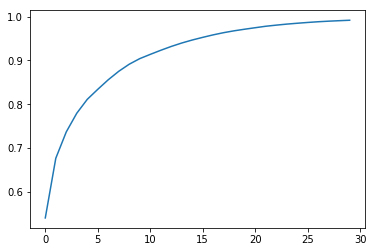

In [22]:
import matplotlib.pylab as plt
plt.plot(cum_var_expl)
plt.show()

In [26]:
np.nonzero(cum_var_expl > 0.99)[0][0]

28

In [27]:
np.nonzero(cum_var_expl > 0.95)[0][0]

15

In [30]:
pca16 = decomposition.PCA(n_components=16)
pca16.fit(vectors)

PCA(copy=True, iterated_power='auto', n_components=16, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [32]:
pca16.explained_variance_ratio_.sum()

0.9528185

In [35]:
pca32 = decomposition.PCA(n_components=32)
pca32.fit(vectors)

PCA(copy=True, iterated_power='auto', n_components=32, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [36]:
pca32.explained_variance_ratio_.sum()

0.9933731

In [37]:
vectors_proj16 = list(pca16.transform(meshmeta.mesh(f).vertices) for f in fs)
vectors_proj32 = list(pca32.transform(meshmeta.mesh(f).vertices) for f in fs)

In [43]:
def read_centers(fname):
    assert os.path.isfile(fname)
    with h5py.File(fname) as f:
        return f["centers"].value
    
def write_h5(vectors, centers, fname):
    with h5py.File(fname) as f:
        f.create_dataset("vertices", data=vectors, compression="gzip")
        f.create_dataset("centers", data=centers, compression="gzip")

In [39]:
pca16dir = f"{INF_DIR}/proj16"
pca32dir = f"{INF_DIR}/proj32"
os.makedirs(pca16dir)
os.makedirs(pca32dir)

In [44]:
for (f, vs16, vs32) in zip(fs, vectors_proj16, vectors_proj32):
    base = os.path.basename(f)
    centers = read_centers(f)
    
    write_h5(vs16, centers, f"{pca16dir}/{base}")
    write_h5(vs32, centers, f"{pca32dir}/{base}")